In [1]:
import pandas as pd
import numpy as np
import scipy
import datetime
import statistics as stats
import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from jupyterthemes import jtplot
from cycler import cycler
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import missingno as msno
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import impute
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, precision_score, \
fbeta_score, f1_score, recall_score, accuracy_score, roc_auc_score, make_scorer
#!jt -r
!jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 95% -T

Using TensorFlow backend.


## Import

In [2]:
def import_files(path_name, name):
    file = path_name+name
    df = pd.read_csv(file, delimiter=',')
    return df

In [3]:
project_dir = str(os.path.dirname((os.path.abspath(''))))
sys.path.append(project_dir)
print(project_dir)
figures_folder = project_dir + '/Images/'
base_path = project_dir + '/data/'
print(base_path)
df = import_files(path_name=base_path, name='preprocessed_data.csv')
df.head()

/Users/samypalaniappan/Desktop/02_Metis_working_dir/Project/Project 3
/Users/samypalaniappan/Desktop/02_Metis_working_dir/Project/Project 3/data/


,Unnamed: 0,age,totChol,MAP,BMI,cigsPerDay,heartRate,glucose,male,prevalentHyp,TenYearCHD
0,0,39,195.0,82.000000,26.97,0.0,80.0,77.0,1,0,0
1,1,46,250.0,94.333333,28.73,0.0,95.0,76.0,0,0,0
2,2,48,245.0,95.833333,25.34,20.0,75.0,70.0,1,0,0
3,3,61,225.0,113.333333,28.58,30.0,65.0,103.0,0,1,1
4,4,46,285.0,99.333333,23.10,23.0,85.0,85.0,0,0,0


In [4]:
def data_scaling(df, col_cont, df_disc):
    df_disc = df[col_disc]
    df_cont = df[col_cont]
    std = StandardScaler()
    std.fit_transform(df_cont.values)
    df_cont = std.transform(df_cont.values)
    df_cont = pd.DataFrame(df_cont)
    df_cont.columns = col_cont
    scaled_df = pd.concat([df_disc, df_cont], axis=1, sort=False)
    return scaled_df

In [5]:
# file import and scaling
print(df.columns)
col_cont = [ 'age', 'totChol', 'MAP', 'BMI', 'cigsPerDay', 'heartRate', 'glucose']
col_disc = ['TenYearCHD', 'male', 'prevalentHyp']
scaled_df = data_scaling(df, col_cont, col_disc)
scaled_df = scaled_df.dropna()
scaled_df.shape

Index(['Unnamed: 0', 'age', 'totChol', 'MAP', 'BMI', 'cigsPerDay', 'heartRate',
       'glucose', 'male', 'prevalentHyp', 'TenYearCHD'],
      dtype='object')


(4131, 10)

In [6]:
# Ordering columns according to preknown feature importance.Features are also added / removed here.
cols = ['age', 'totChol', 'MAP', 'BMI', 'cigsPerDay', 'heartRate', \
                      'glucose', 'male', 'prevalentHyp', 'TenYearCHD']
scaled_df = scaled_df[cols]
scaled_df.head()

,age,totChol,MAP,BMI,cigsPerDay,heartRate,glucose,male,prevalentHyp,TenYearCHD
0,-1.230197,-0.942980,-1.204592,0.096125,-0.756377,0.342776,-0.215105,1,0,0
1,-0.412638,0.300210,-0.347825,0.292679,-0.756377,1.586779,-0.258551,0,0,0
2,-0.179050,0.187193,-0.243624,-0.085912,0.920582,-0.071892,-0.519229,1,0,0
3,1.339273,-0.264876,0.972058,0.275927,1.759062,-0.901227,0.914498,0,1,1
4,-0.412638,1.091331,-0.000488,-0.336072,1.172126,0.757444,0.132465,0,0,0


In [7]:
X=scaled_df.iloc[:,:-1]
y=scaled_df.iloc[:,-1]
# print(X)
# print(y)

In [10]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=4444)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3,  random_state=4444)

## Dummy Classifier

In [11]:
dclf = DummyClassifier(random_state = 0)
dclf.fit(X_train, y_train)
score = dclf.score(X_test, y_test)
# perform 10 fols CV
recall = cross_val_score(dclf, X_train, y_train, cv=10,scoring="recall").mean()
precision = cross_val_score(dclf, X_train, y_train, cv=10,scoring="precision").mean()
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print("accuracy on dummy classifier: {:6.4f}".format(cross_val_score(dclf, X_train, y_train, cv=10,scoring="accuracy").mean()))
print("Recall on dummy classifier: {:6.4f}".format(cross_val_score(dclf, X_train, y_train, cv=10,scoring="recall").mean()))
print("Precision on dummy classifier: {:6.4f}".format(cross_val_score(dclf, X_train, y_train, cv=10,scoring="precision").mean()))
#print("Accuracy on dummy classifier: {:6.4f}".format(cross_val_score(dclf, X_train, y_train, cv=10,scoring="f1-score").mean()))

0.13396740853465222
accuracy on dummy classifier: 0.7573
Recall on dummy classifier: 0.1278
Precision on dummy classifier: 0.1407


/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: 

## Defining All Functions

### Instancing the models

In [12]:
def train_test_instant(X_train, y_train):
    LogR = LogisticRegression(solver= 'liblinear')
    LogR.fit(X_train, y_train)

    KNN = KNeighborsClassifier(n_neighbors=3, weights='distance')
    KNN.fit(X_train, y_train)

    GNB = GaussianNB()
    GNB.fit(X_train, y_train)

    SVC1 = SVC(kernel = 'rbf')
    SVC1.fit(X_train, y_train)

    DTC = DecisionTreeClassifier(max_depth=7)
    DTC.fit(X_train, y_train)

    RFC = RandomForestClassifier(n_estimators=10)
    RFC.fit(X_train, y_train)

    IFC = IsolationForest()
    IFC.fit(X_train, y_train)

    XGB = XGBClassifier()
    XGB.fit(X_train, y_train)

    ABC = AdaBoostClassifier()
    ABC.fit(X_train, y_train)

    classifiers = [LogR, KNN, GNB, SVC1, DTC, RFC, XGB, ABC, IFC]
    models = ['LogR', 'KNN', 'GNB', 'SVC', 'DTC', 'RFC', 'XGB', 'ABC', 'IFC']
    
    return classifiers, models

In [13]:
def train_test_eval(classifiers, models, X_test):
    error_metrics = {}
    for i in range(7):
        model = models[i]
        accuracy = accuracy_score(y_test, classifiers[i].predict(X_test))
        precision = precision_score(y_test, classifiers[i].predict(X_test)) 
        recall = recall_score(y_test, classifiers[i].predict(X_test)) 
        f1 = f1_score(y_test, classifiers[i].predict(X_test)) 
        AUC = roc_auc_score(y_test, classifiers[i].predict(X_test))
        error_metrics[model] = {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1-Score':f1, 'AUC-Score':AUC}

    accu_IF = accuracy_score(y_test, classifiers[8].predict(X_test)) 
    prec_IF = precision_score(y_test, classifiers[8].predict(X_test), average='macro') 
    reca_IF = recall_score(y_test, classifiers[8].predict(X_test), average='macro') 
    f1_IF = f1_score(y_test, classifiers[8].predict(X_test), average='macro')     
    AUC_IF = roc_auc_score(y_test, classifiers[8].predict(X_test), average='macro')
    error_metrics['IFC'] = {'Accuracy':accu_IF, 'Precision':prec_IF, 'Recall':reca_IF, 'F1-Score':f1_IF, 'AUC-Score':AUC_IF}

    train_test_sc = pd.DataFrame(error_metrics)
    train_test_scores = train_test_sc.transpose()
    print(train_test_scores)
    return train_test_scores

In [14]:
def plot_metrics(error_scores, subhead):
    plt.figure(figsize=(12,6))
    plt.plot(error_scores['Accuracy'], marker = 'o', label=error_scores.columns[0])
    plt.plot(error_scores['Precision'], marker = '+', label=error_scores.columns[1])
    plt.plot(error_scores['Recall'], marker = '^', label=error_scores.columns[2])
    plt.plot(error_scores['F1-Score'], marker = 'v', label=error_scores.columns[3])
    plt.plot(error_scores['AUC-Score'], marker = '*', label=error_scores.columns[4])

    plt.ylabel('Metrics', fontsize='16')
    plt.xlabel('Model', fontsize='16')
    plt.title('Test Scores - from Train-Test Split'+subhead, fontsize='24')
    plt.legend(fontsize='16', loc='lower left')
    plt.show();

In [15]:
def auc_roc_curve(classifiers, models, X_test, subhead):
    del(classifiers[3])
    del(models[3])
    default_cycler = (cycler(color=['r', 'g', 'b', 'y', 'c', 'm', 'crimson']) +
                  cycler(marker=['o', '+', '*', 'v', '^', 'x', '.']))
    AUC = []
    plt.rc('lines', linewidth=4)
    plt.rc('axes', prop_cycle=default_cycler)
    plt.figure(figsize=(12,6))
    for i in range(len(classifiers)-1):
        fpr, tpr, thresholds = roc_curve(y_test, classifiers[i].predict_proba(X_test)[:,1])
        AUC.append(roc_auc_score(y_test, classifiers[i].predict_proba(X_test)[:,1]))
        plt.plot(fpr, tpr, linewidth=3, label=models[i])
    plt.ylabel('TPR(Recall)', fontsize='16')
    plt.xlabel('FPR', fontsize='16')
    plt.title('ROC Curve with '+subhead, fontsize='24')
    plt.legend(fontsize='16')
    plt.show()
    AUC_scores = dict(zip(models, AUC))
    return AUC_scores

In [16]:
def cross_val_metrics(X_train, y_train, classifiers_cv, models, subhead):
    CV_metrics = {}
    for i in range(8):
        model = models[i]
        accuracy_cv = cross_val_score(classifiers_cv[i], X_train, y_train, cv=3, scoring='accuracy')
        accu_mean = np.mean(accuracy_cv, axis=0)
        precision_cv = cross_val_score(classifiers_cv[i], X_train, y_train,  cv=3, scoring='precision') 
        prec_mean = np.mean(precision_cv, axis=0)
        recall_cv = cross_val_score(classifiers_cv[i], X_train, y_train,  cv=3, scoring='recall') 
        reca_mean = np.mean(recall_cv, axis=0)
        f1_cv = cross_val_score(classifiers_cv[i], X_train, y_train, cv=3, scoring='f1') 
        f1_mean = np.mean(f1_cv, axis=0)
        auc_cv = cross_val_score(classifiers_cv[i], X_train, y_train, cv=3, scoring='roc_auc') 
        auc_mean = np.mean(auc_cv, axis=0)
        CV_metrics[model] = {'Accuracy':accu_mean, 'Precision':prec_mean, 'Recall':reca_mean, 'F1-Score':f1_mean, 'AUC-Score':auc_mean}
    CV_scores = pd.DataFrame(CV_metrics)
    #CV_scores['oversampling']=subhead
    CV_scores = CV_scores.transpose()
    return CV_scores   

In [17]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    confusion = confusion_matrix(y, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['-ve', '+ve'],
           yticklabels=['-ve', '+ve']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.set_cmap('BuGn')

## No Over-sampling

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Accuracy  Precision    Recall  F1-Score  AUC-Score
LogR  0.852535   0.615385  0.061069  0.111111   0.527142
KNN   0.811060   0.273973  0.152672  0.196078   0.540379
GNB   0.831797   0.377049  0.175573  0.239583   0.562006
SVC   0.847926   0.333333  0.007634  0.014925   0.502460
DTC   0.824885   0.294118  0.114504  0.164835   0.532829
RFC   0.832949   0.305556  0.083969  0.131737   0.525024
XGB   0.847926   0.478261  0.083969  0.142857   0.533844
IFC   0.104839   0.042247  0.231552  0.071457   0.421955


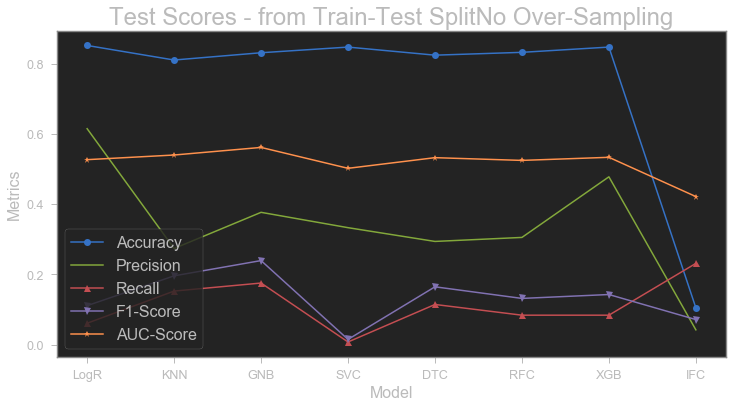

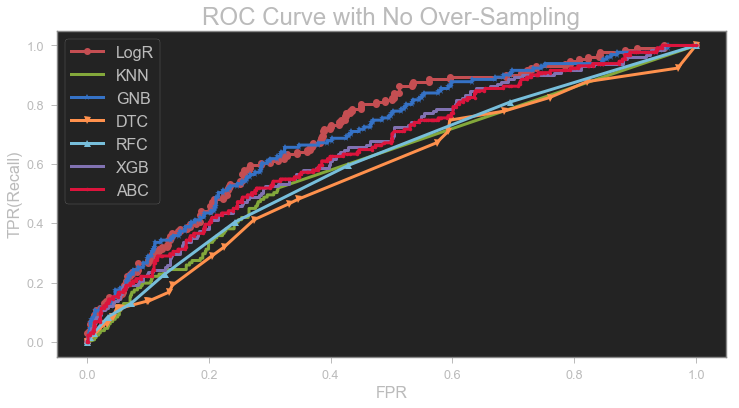

AUC_scores - No Oversampling
{'LogR': 0.7166457787398883, 'KNN': 0.6042497436481713, 'GNB': 0.7030772577086807, 'DTC': 0.576739826198639, 'RFC': 0.6079733186945218, 'XGB': 0.6563435425233306, 'ABC': 0.6560638859829928}


Model Metrics - No Oversampling


,Accuracy,Precision,Recall,F1-Score,AUC-Score
LogR,0.852535,0.615385,0.061069,0.111111,0.527142
KNN,0.811060,0.273973,0.152672,0.196078,0.540379
GNB,0.831797,0.377049,0.175573,0.239583,0.562006
SVC,0.847926,0.333333,0.007634,0.014925,0.502460
DTC,0.824885,0.294118,0.114504,0.164835,0.532829
RFC,0.832949,0.305556,0.083969,0.131737,0.525024
XGB,0.847926,0.478261,0.083969,0.142857,0.533844
IFC,0.104839,0.042247,0.231552,0.071457,0.421955


In [18]:
subhead = 'No Over-Sampling'
classifiers, models = train_test_instant(X_train, y_train)
model_metrics = train_test_eval(classifiers, models, X_test);
plot_metrics(model_metrics, subhead)
AUC_scores = auc_roc_curve(classifiers, models, X_test, subhead)
print('AUC_scores - No Oversampling')
print(AUC_scores)
print('\r\n')
print('Model Metrics - No Oversampling')
model_metrics

## Oversampling Techniques ROS, SMOTE, and ADASYN tested

In [19]:
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X_train,y_train)
X_sm, y_sm = SMOTE(random_state=42).fit_sample(X_train,y_train)
X_ad, y_ad = ADASYN(random_state=42).fit_sample(X_train,y_train)

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Accuracy  Precision    Recall  F1-Score  AUC-Score
LogR  0.630184   0.240437  0.671756  0.354125   0.647275
KNN   0.713134   0.226852  0.374046  0.282421   0.573726
GNB   0.775346   0.297468  0.358779  0.325260   0.604084
SVC   0.672811   0.247525  0.572519  0.345622   0.631578
DTC   0.627880   0.190323  0.450382  0.267574   0.554906
RFC   0.823733   0.288462  0.114504  0.163934   0.532150
XGB   0.685484   0.238971  0.496183  0.322581   0.607657
IFC   0.114055   0.044236  0.251908  0.075257   0.438921


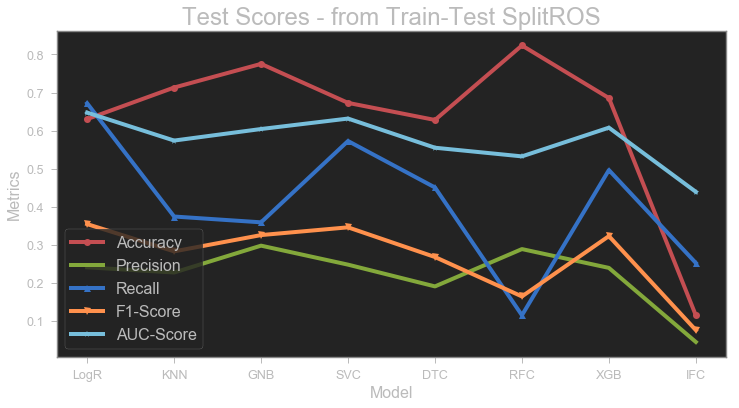

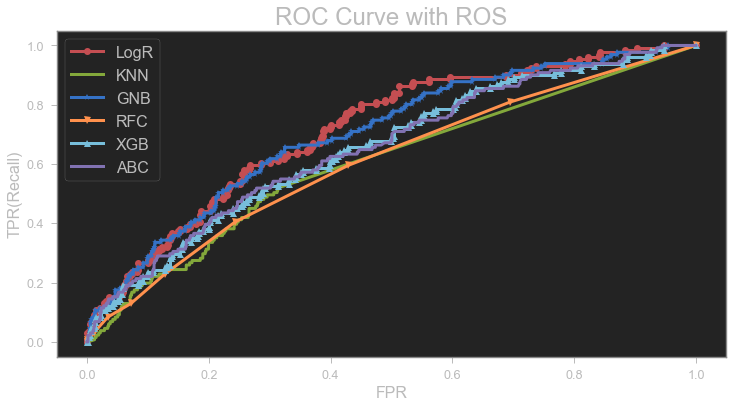

AUC_scores - ROS
{'LogR': 0.7166457787398883, 'KNN': 0.6042497436481713, 'GNB': 0.7030772577086807, 'RFC': 0.6079733186945218, 'XGB': 0.6563435425233306, 'ABC': 0.6560638859829928}


Model Metrics - ROS


,Accuracy,Precision,Recall,F1-Score,AUC-Score
LogR,0.630184,0.240437,0.671756,0.354125,0.647275
KNN,0.713134,0.226852,0.374046,0.282421,0.573726
GNB,0.775346,0.297468,0.358779,0.325260,0.604084
SVC,0.672811,0.247525,0.572519,0.345622,0.631578
DTC,0.627880,0.190323,0.450382,0.267574,0.554906
RFC,0.823733,0.288462,0.114504,0.163934,0.532150
XGB,0.685484,0.238971,0.496183,0.322581,0.607657
IFC,0.114055,0.044236,0.251908,0.075257,0.438921


In [20]:
subhead = 'ROS'
ros_classifiers, ros_models = train_test_instant(X_ros, y_ros)
model_metrics = train_test_eval(ros_classifiers, ros_models, X_test);
plot_metrics(model_metrics, subhead)
AUC_scores = auc_roc_curve(classifiers, models, X_test, subhead)
print('AUC_scores - ROS')
print(AUC_scores)
print('\r\n')
print('Model Metrics - ROS')
model_metrics

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Accuracy  Precision    Recall  F1-Score  AUC-Score
LogR  0.629032   0.242588  0.687023  0.358566   0.652874
KNN   0.672811   0.213483  0.435115  0.286432   0.575088
GNB   0.745392   0.281553  0.442748  0.344214   0.620967
SVC   0.656682   0.222591  0.511450  0.310185   0.596973
DTC   0.616359   0.201183  0.519084  0.289979   0.576367
RFC   0.779954   0.272727  0.274809  0.273764   0.572276
XGB   0.717742   0.247788  0.427481  0.313725   0.598408
IFC   0.103687   0.041609  0.229008  0.070423   0.415425


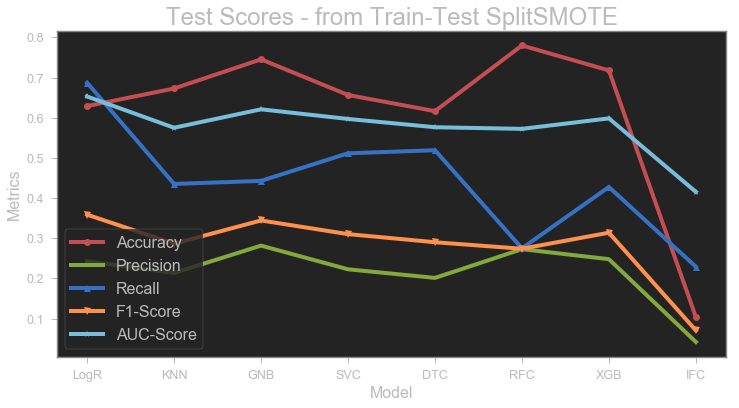

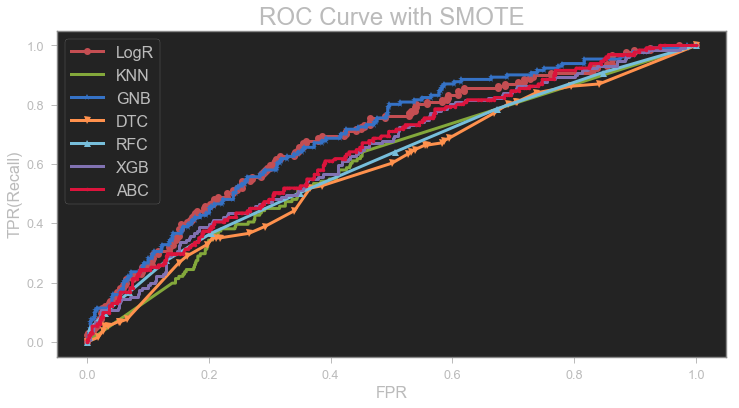

AUC_scores - ROS
{'LogR': 0.6900991227070753, 'KNN': 0.5988326928853305, 'GNB': 0.6993485038375091, 'DTC': 0.5817063192020466, 'RFC': 0.6098169803308232, 'XGB': 0.6380312179560215, 'ABC': 0.6466021730348949}


Model Metrics - ROS


,Accuracy,Precision,Recall,F1-Score,AUC-Score
LogR,0.629032,0.242588,0.687023,0.358566,0.652874
KNN,0.672811,0.213483,0.435115,0.286432,0.575088
GNB,0.745392,0.281553,0.442748,0.344214,0.620967
SVC,0.656682,0.222591,0.511450,0.310185,0.596973
DTC,0.616359,0.201183,0.519084,0.289979,0.576367
RFC,0.779954,0.272727,0.274809,0.273764,0.572276
XGB,0.717742,0.247788,0.427481,0.313725,0.598408
IFC,0.103687,0.041609,0.229008,0.070423,0.415425


In [21]:
subhead = 'SMOTE'
classifiers, models = train_test_instant(X_sm, y_sm)
model_metrics = train_test_eval(classifiers, models, X_test);
plot_metrics(model_metrics, subhead)
AUC_scores = auc_roc_curve(classifiers, models, X_test, subhead)
print('AUC_scores - ROS')
print(AUC_scores)
print('\r\n')
print('Model Metrics - ROS')
model_metrics

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Accuracy  Precision    Recall  F1-Score  AUC-Score
LogR  0.622120   0.240106  0.694656  0.356863   0.651942
KNN   0.663594   0.221453  0.488550  0.304762   0.591629
GNB   0.755760   0.287958  0.419847  0.341615   0.617658
SVC   0.611751   0.198830  0.519084  0.287526   0.573653
DTC   0.576037   0.196931  0.587786  0.295019   0.580867
RFC   0.764977   0.237410  0.251908  0.244444   0.554041
XGB   0.691244   0.227092  0.435115  0.298429   0.585943
IFC   0.088710   0.039066  0.195929  0.065144   0.400406


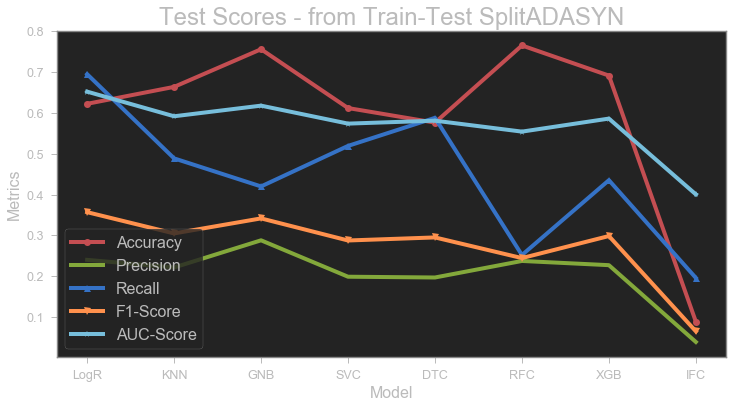

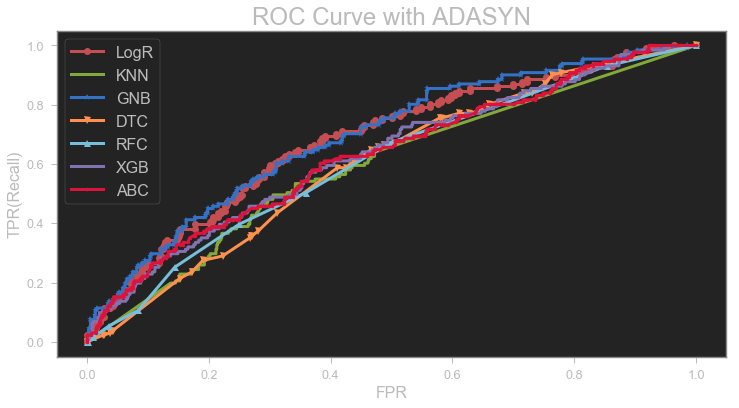

AUC_scores - ADASYN
{'LogR': 0.6818855065408559, 'KNN': 0.5948812495468528, 'GNB': 0.6938900224760998, 'DTC': 0.6016137218142459, 'RFC': 0.6064455653723057, 'XGB': 0.6319150258423358, 'ABC': 0.6312573150900598}


Model Metrics - ADASYN


,Accuracy,Precision,Recall,F1-Score,AUC-Score
LogR,0.622120,0.240106,0.694656,0.356863,0.651942
KNN,0.663594,0.221453,0.488550,0.304762,0.591629
GNB,0.755760,0.287958,0.419847,0.341615,0.617658
SVC,0.611751,0.198830,0.519084,0.287526,0.573653
DTC,0.576037,0.196931,0.587786,0.295019,0.580867
RFC,0.764977,0.237410,0.251908,0.244444,0.554041
XGB,0.691244,0.227092,0.435115,0.298429,0.585943
IFC,0.088710,0.039066,0.195929,0.065144,0.400406


In [22]:
subhead = 'ADASYN'
classifiers, models = train_test_instant(X_ad, y_ad)
model_metrics = train_test_eval(classifiers, models, X_test);
plot_metrics(model_metrics, subhead)
AUC_scores = auc_roc_curve(classifiers, models, X_test, subhead)
print('AUC_scores - ADASYN')
print(AUC_scores)
print('\r\n')
print('Model Metrics - ADASYN')
model_metrics

## Cross Validation

['LogR', 'KNN', 'GNB', 'SVC', 'DTC', 'RFC', 'XGB', 'ABC', 'IFC']


Model Metrics - SMOTE
      Accuracy  Precision    Recall  F1-Score  AUC-Score
LogR  0.676996   0.670534  0.696403  0.683132   0.732768
KNN   0.827349   0.753490  0.973345  0.849372   0.911144
GNB   0.597332   0.679066  0.370244  0.475822   0.680844
SVC   0.733480   0.723454  0.754900  0.738565   0.795279
DTC   0.706260   0.684761  0.774663  0.727141   0.769918
RFC   0.842705   0.846265  0.827915  0.836233   0.912909
XGB   0.781575   0.775611  0.794858  0.782231   0.871735
ABC   0.730013   0.724057  0.740987  0.732048   0.806739


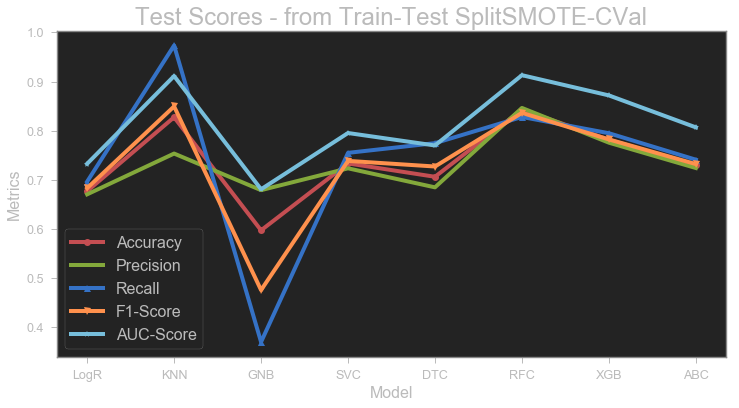

In [23]:
subhead = 'SMOTE-CVal'
classifiers, models = train_test_instant(X_ad, y_ad)
# classifiers.pop()
# models.pop()
print(models)
cv_scores = cross_val_metrics(X_sm, y_sm, classifiers, models, subhead)
# print('AUC_scores - ROS')
# print(AUC_scores)
print('\r\n')
print('Model Metrics - SMOTE')
print(cv_scores)
plot_metrics(cv_scores, subhead)

### Tuning

Fitting 15 folds for each of 432 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   20.1s


Best Score:  0.8250451446471346
Best Params:  {'C': 1e-06, 'class_weight': {1: 17500, 0: 6000}, 'penalty': 'l1', 'solver': 'liblinear'}


Accuracy of RandomForestGridSearch is 0.7949
Precision of RandomForestGridSearch is 0.2673
Recall of RandomForestGridSearch is 0.2061
F1-Score of RandomForestGridSearch is 0.2328


LogisticRegression(C=1e-06, class_weight={0: 6000, 1: 17500}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Index(['age', 'totChol', 'MAP', 'BMI', 'cigsPerDay', 'heartRate', 'glucose',
       'male', 'prevalentHyp'],
      dtype='object')


[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:   22.5s finished


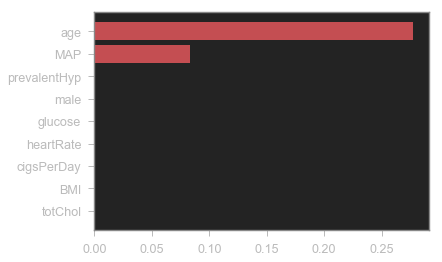

,age,totChol,MAP,BMI,cigsPerDay,heartRate,glucose,male,prevalentHyp
0,-1.230197,-0.942980,-1.204592,0.096125,-0.756377,0.342776,-0.215105,1,0
1,-0.412638,0.300210,-0.347825,0.292679,-0.756377,1.586779,-0.258551,0,0
2,-0.179050,0.187193,-0.243624,-0.085912,0.920582,-0.071892,-0.519229,1,0
3,1.339273,-0.264876,0.972058,0.275927,1.759062,-0.901227,0.914498,0,1
4,-0.412638,1.091331,-0.000488,-0.336072,1.172126,0.757444,0.132465,0,0
...,...,...,...,...,...,...,...,...,...
4126,2.156831,-1.372446,1.481487,-0.331604,-0.756377,-1.315895,-0.128212,1,1
4127,0.054538,1.724227,1.504643,-0.015554,-0.672529,-0.818294,0.175912,1,1
4128,0.171332,-0.671739,-0.266780,-0.714662,2.849085,-0.901227,-0.606121,1,0
4129,-0.646227,-0.603928,0.057402,-0.776085,0.501342,0.840377,0.000682,0,0


In [24]:
penalty = ['l1', 'l2']
C = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
class_weight = [{1:35000, 0:3000}, {1:35000, 0:6000},{1:17500, 0:6000}, {1:35000, 0:1500}, {1:35000, 0:800}, {1:35000, 0:12000}]
solver = ['liblinear', 'saga', 'newton-cg', 'lbfgs']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)
LogR = LogisticRegression()
grid = GridSearchCV(estimator=LogR,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=15,
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)
bst_parms = grid.best_params_
best_grid = grid.best_estimator_
GS_accuracy = accuracy_score(y_test, best_grid.predict(X_test)) 
GS_precision = precision_score(y_test, best_grid.predict(X_test)) 
GS_recall = recall_score(y_test, best_grid.predict(X_test)) 
GS_f1 = 2 * (GS_precision * GS_recall) / (GS_precision + GS_recall)
print('\r\n')
print(f'Accuracy of RandomForestGridSearch is {GS_accuracy:2.4f}')
print(f'Precision of RandomForestGridSearch is {GS_precision:2.4f}')
print(f'Recall of RandomForestGridSearch is {GS_recall:2.4f}')
print(f'F1-Score of RandomForestGridSearch is {GS_f1:2.4f}')
print('\r\n')
print(best_grid)
print(X_test.columns)
feat_imp = dict(zip(X_test.columns, best_grid.coef_[0]))
#print(feat_imp)
sorted_dict = {K: V for K, V in sorted(feat_imp.items(), key=lambda item: item[1], reverse=False)}
plt.barh(range(len(sorted_dict)), list(sorted_dict.values()), align='center')
plt.yticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.show();
feat_imp
X

Threshold = 0.4
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      3517
           1       0.23      0.68      0.35       614

    accuracy                           0.62      4131
   macro avg       0.58      0.65      0.54      4131
weighted avg       0.82      0.62      0.68      4131



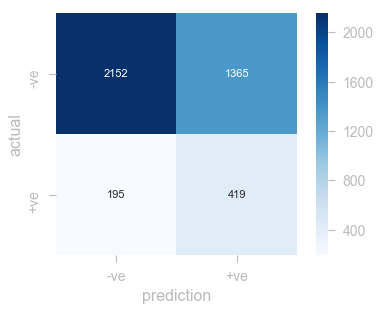

In [25]:
threshold = 0.4
print(f'Threshold = {threshold}')
print(classification_report(y, best_grid.predict_proba(X)[:, 1] > threshold))
make_confusion_matrix(best_grid, threshold)
plt.set_cmap('BuGn')

In [26]:
df_proba = df
df_proba['proba']=best_grid.predict_proba(df.iloc[:,:-1])
df.to_csv(r'df_proba.csv')

ValueError: X has 10 features per sample; expecting 9

In [ ]:
from pprint import pprint
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20, 25],
    'max_features': [4, 6, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [1500, 2000, 2500]
}
pprint(param_grid)

In [ ]:
rf = RandomForestClassifier()
class_weights = {0: 1800, 1: 35000}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='f1', cv = 10, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_sm, y_sm)

In [ ]:
bst_parms = grid_search.best_params_
best_grid = grid_search.best_estimator_
GS_accuracy = accuracy_score(y_test, best_grid.predict(X_test)) 
GS_precision = precision_score(y_test, best_grid.predict(X_test)) 
GS_recall = recall_score(y_test, best_grid.predict(X_test)) 
GS_f1 = 2 * (GS_precision * GS_recall) / (GS_precision + GS_recall)
print(f'Accuracy of RandomForestGridSearch is {GS_accuracy:2.4f}')
print(f'Precision of RandomForestGridSearch is {GS_precision:2.4f}')
print(f'Recall of RandomForestGridSearch is {GS_recall:2.4f}')
print(f'F1-Score of RandomForestGridSearch is {GS_f1:2.4f}')
print(best_grid)
feat_imp = dict(zip(X.columns, best_grid.feature_importances_))
sorted_dict = {K: V for K, V in sorted(feat_imp.items(), key=lambda item: item[1], reverse=False)}
print(sorted_dict)
plt.barh(range(len(sorted_dict)), list(sorted_dict.values()), align='center')
plt.yticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.show()
feat_imp
X_test

In [ ]:
threshold = 0.4
print(f'Threshold = {threshold}')
print(classification_report(y, best_grid.predict_proba(X)[:, 1] > threshold))
make_confusion_matrix(best_grid, threshold)

In [ ]:
import pickle
pickle.dump(best_grid, open("RFGS_best_revised.p", "wb"))

In [ ]:
KNNw_metrics = {}
KNNu_metrics = {}
for k in [3, 5, 10, 15]:
    KNNw = KNeighborsClassifier(n_neighbors=k, weights='distance')
    accuracy_cv = cross_val_score(KNNw, X_ad, y_ad, cv=5, scoring='accuracy')
    accu_mean_w = np.mean(accuracy_cv, axis=0)
    precision_cv = cross_val_score(KNNw, X_ad, y_ad, cv=5, scoring='precision') 
    prec_mean_w = np.mean(precision_cv, axis=0)
    recall_cv = cross_val_score(KNNw, X_ad, y_ad, cv=5, scoring='recall') 
    reca_mean_w = np.mean(recall_cv, axis=0)
    f1_cv = cross_val_score(KNNw, X_ad, y_ad, cv=5, scoring='f1') 
    f1_mean_w = np.mean(f1_cv, axis=0)
    KNNw_metrics[k] = {'Accuracy':accu_mean_w, 'Precision':prec_mean_w, 'Recall':reca_mean_w, 'F1-Score':f1_mean_w}
KNNw_scores = pd.DataFrame(KNNw_metrics)
KNNw_scores = KNNw_scores.transpose()
print('KNN-Weighted by Distance')
print(KNNw_scores)
print('\r\n')
    
for k in [3, 5, 10, 15]:
    KNNu = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    accuracy_cv = cross_val_score(KNNu, X_ad, y_ad, cv=5, scoring='accuracy')
    accu_mean_u = np.mean(accuracy_cv, axis=0)
    precision_cv = cross_val_score(KNNu, X_ad, y_ad, cv=5, scoring='precision') 
    prec_mean_w = np.mean(precision_cv, axis=0)
    recall_cv = cross_val_score(KNNu, X_ad, y_ad, cv=5, scoring='recall') 
    reca_mean_u = np.mean(recall_cv, axis=0)
    f1_cv = cross_val_score(KNNu, X_ad, y_ad, cv=5, scoring='f1') 
    f1_mean_u = np.mean(f1_cv, axis=0)
    KNNu_metrics[k] = {'Accuracy':accu_mean_u, 'Precision':prec_mean_w, 'Recall':reca_mean_u, 'F1-Score':f1_mean_u}
KNNu_scores = pd.DataFrame(KNNu_metrics)
KNNu_scores = KNNu_scores.transpose()
print('KNN-Uniformly Weighted')
print(KNNu_scores)